# Task 4 - Anomaly detection using autoencoders

# Topics

In this exercise sheet, you will:
- Work with a dataset for `dynamic behavior analysis of automotive software systems`.
- Implement autoencoders (AEs) for unsupervised anomaly detection.
- Compare MLP-based and CNN-based AEs.
- Vary architecture to improve model performance.
- Apply scheduled learning rate.
- Evaluate the performance of the model.

*We are looking forward to seeing your solutions! Have fun!*

# Related publications
 - Abboush, M.; Bamal, D.; Knieke, C.; Rausch, A. Hardware-in-the-Loop-Based Real-Time Fault Injection Framework for Dynamic Behavior Analysis of Automotive Software Systems. Sensors 2022, 22, 1360. https://doi.org/10.3390/s22041360 

 - Abboush, M.; Bamal, D.; Knieke, C.; Rausch, A. Intelligent Fault Detection and Classification Based on Hybrid Deep Learning Methods for Hardware-in-the-Loop Test of Automotive Software Systems. Sensors 2022, 22, 4066. https://doi.org/10.3390/s22114066 

## Imports

In [51]:
import numpy as np
import pandas as pd
import glob

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, callbacks
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Conv1DTranspose, UpSampling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers.schedules import ExponentialDecay


SEED = 24
np.random.seed(SEED)

## System checks


In [21]:
gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')
print(gpus)
print(cpus)

[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Choose your device for computation. CPU or one of your CUDA devices.

In [22]:
tf.config.set_visible_devices(gpus, 'GPU')

# Subtask 2.1

## Loading the dataset and pre-processing

The dataset consists of time-series sensor measurements of healthy and faulty operation of the system. The fault type in each file is as following:

| File name | Fault type|
|------|------|
| Faulty_0 | Stuck-at fault |
| Faulty_1 | Offset/bias fault |
| Faulty_2 | Noise fault |
| Faulty_3 | Packet loss fault |
| Faulty_4 | Stuck-at fault |
| Faulty_5 | Stuck-at & Noise faults |

In [23]:
data_dir = './Data/'
file_names_test = glob.glob(data_dir + 'Faulty*')
file_names_train = ['Healthy.csv']
file_names_test

['./Data\\Faulty_0.csv',
 './Data\\Faulty_1.csv',
 './Data\\Faulty_2.csv',
 './Data\\Faulty_3.csv',
 './Data\\Faulty_4.csv',
 './Data\\Faulty_5.csv']

In [24]:
data_train = []
for f in file_names_train:
    data_train.append(pd.read_csv(data_dir + f))

data_test = []
for f in file_names_test:
    data_test.append(pd.read_csv(f))

#### TODO

- Visualize `ENGINE_RPM` of the healthy and one of the faulty time-series.

**Note:** Do not forget to add title, axis labels and a legend!
This applies in general, please keep in mind.

Text(0.5, 1.0, 'ENGINE_RPM of Healthy and Faulty Time Series')

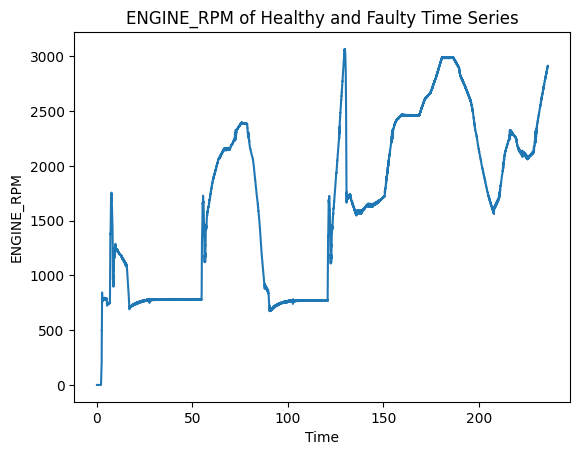

In [25]:
plt.plot(data_test[0]['time'] ,data_train[0]['ENGINE_RPM'])
plt.xlabel('Time')
plt.ylabel('ENGINE_RPM')
plt.title('ENGINE_RPM of Healthy and Faulty Time Series')


Let us extract the labels from the data and preserve them for later. Note that we will do an unsupervised anomaly detection. Therefore, we do not need labels for training.

In [26]:
y_train = []
for df in data_train:
    y_train.append(df['label'])

y_test = []
for df in data_test:
    y_test.append(df['label'])

We drop columns `time` and `label`, since they are not needed for training.

In [27]:
for df in data_train:
    df.drop(columns = ['label', 'time'], inplace = True)

for df in data_test:
    df.drop(columns = ['label', 'time'], inplace = True)

## Pre-processing

#### TODO 
- Scale the data using `min-max scaler`.



In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_scale = ['ENGINE_RPM', 'Trq_MeanEff_Engine_Mod[Nm]', 'T_Water[degC]', 'p_InMan[Pa]', 'p_Rail[bar]', 'v_vehicle[km|h]']

train_scaled_data = []
for train_df in data_train:
    train_scaled_df = train_df.copy()
    train_scaled_df[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
    train_scaled_data.append(train_scaled_df)

test_scaled_data = []
for test_df in data_test:
    test_scaled_df = test_df.copy()
    test_scaled_df[columns_to_scale] = scaler.transform(test_df[columns_to_scale])
    test_scaled_data.append(test_scaled_df)


In [29]:
data_train = train_scaled_data 
data_test = train_scaled_data 

Since we are working with time-series data, it is beneficial to consider a sequence of time steps as the input of the model. In this way it is possible to exploit and learn the temporal dependencies in the data.

To this end, let us consider a sliding window with the length of $\ell$ and slide it over the whole time series with a stride of $s$ to generate our sequences. In this way, we will have:

$ X_0 = [x_0, ..., x_{\ell}]$

$ X_1 = [x_s, ..., x_{\ell+s}]$

$ X_2 = [x_{2s}, ..., x_{\ell+2s}]$

...

$ X_n = [x_{n\times s}, ..., x_{\ell+ n \times s}]$

as our input samples, where $x_t \in \mathbb{R}^p$ is the state of the system at time $t$. 

In [30]:
def make_sequences(data, l, stride = 1):
    sequences = [data[i:i+l] for i in range(0, len(data) - l, stride)]
    return np.array(sequences)

#### TODO
 - Use the function above (`make_sequences`) to generate sequences. Use the sequence length of $\ell = 32$ and stride of 1 for healthy data (for training and validation) and stride of $\ell$ for faulty data (for testing).
 - Consider 80% of the healthy data for training and 20\% of it for validation.

**Note that we fit our model to the healthy data. After the training, we will employ the model to detect anomalies in the faulty time series.**

In [31]:
####################
## YOUR CODE HERE ##
####################
for df in data_train:
    df = make_sequences(df, l=32, stride = 1)

for df in data_test:
    df = make_sequences(df, l=32, stride = 1)

In [32]:
####################
## YOUR CODE HERE ##
####################
df = data_train[0]
total_rows = len(df)
val_proportion = 0.2
val_rows = int(total_rows * val_proportion)
train_df = df.iloc[:-val_rows]
val_df = df.iloc[-val_rows:]

len(train_df), len(val_df)

(17040, 4259)

# Subtask 2.2

## MLP-based autoencoder

#### TODO
 - Consider the size of the bottleneck layer equal to 2.
 - Develop your model and print `model.summary()`.
 - Train the model.
 - Select the best model based on the validation loss.
 - Plot the learning curves.
 - Report the best validation loss you obtained.

In [33]:
####################
## YOUR CODE HERE ##
####################

train_data = np.array(train_df)
val_data = np.array(val_df)
input_dim = train_data.shape[1]

bottleneck_size = 2

input_shape = (input_dim,)

input_layer = Input(shape=input_shape)

encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(32, activation='relu')(encoder)
encoder = Dense(16, activation='relu')(encoder)
bottleneck = Dense(bottleneck_size, activation='relu')(encoder)

decoder = Dense(16, activation='relu')(bottleneck)
decoder = Dense(32, activation='relu')(decoder)
decoder = Dense(64, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='linear')(decoder)

model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_8 (Dense)             (None, 64)                448       
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 2)                 34        
                                                                 
 dense_12 (Dense)            (None, 16)                48        
                                                                 
 dense_13 (Dense)            (None, 32)                544 

Epoch 1/10
1065/1065 [==============================] - 2s 1ms/step - loss: 0.0406 - val_loss: 0.0118
Epoch 2/10
1065/1065 [==============================] - 1s 883us/step - loss: 0.0077 - val_loss: 0.0072
Epoch 3/10
1065/1065 [==============================] - 1s 906us/step - loss: 0.0061 - val_loss: 0.0069
Epoch 4/10
1065/1065 [==============================] - 1s 889us/step - loss: 0.0055 - val_loss: 0.0073
Epoch 5/10
1065/1065 [==============================] - 1s 883us/step - loss: 0.0051 - val_loss: 0.0078
Epoch 6/10
1065/1065 [==============================] - 1s 897us/step - loss: 0.0046 - val_loss: 0.0071


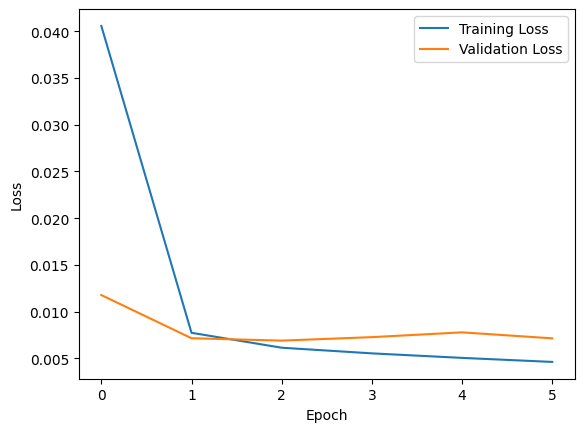

Best Validation Loss:  0.006901454646140337


In [34]:
####################
## YOUR CODE HERE ##
####################

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_data, train_data,
                          validation_data=(val_data, val_data),
                          epochs=10,
                          batch_size=16,
                          callbacks=[early_stopping])

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

best_model = model
best_val_loss = np.min(history.history['val_loss'])
print('Best Validation Loss: ', best_val_loss)


# Subtask 2.3

## CNN-based autoencoder

#### TODO
- Consider the size of the bottleneck layer equal to 2.

 - Develop your model and print `model.summary()`. Use 1D convolution, 1D pooling, and dense layers in the encoder and dense, 1D convolution transpose and 1D up-sampling layers in the decoder.
 - Train the model.
 - Select the best model based on the validation loss.
 - Plot the learning curves.
 - Report the best validation loss you obtained.

In [35]:
train_data = np.array(train_df)
val_data = np.array(val_df)
input_dim = train_data.shape[1]

bottleneck_size = 2

input_shape = (input_dim, 1)

train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))
val_data = np.reshape(val_data, (val_data.shape[0], val_data.shape[1], 1))

input_layer = Input(shape=input_shape)

encoder = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(input_layer)
encoder = MaxPooling1D(pool_size=2)(encoder)
encoder = Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')(encoder)
encoder = MaxPooling1D(pool_size=2)(encoder)
encoder = Dense(4, activation='relu')(encoder)
bottleneck = Dense(bottleneck_size, activation='relu')(encoder)

decoder = Dense(4, activation='relu')(bottleneck)
decoder = UpSampling1D(size=2)(decoder)
decoder = Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')(decoder)
decoder = UpSampling1D(size=3)(decoder)
decoder = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(decoder)
output_layer = Conv1D(filters=1, kernel_size=3, activation='linear', padding='same')(decoder)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 conv1d (Conv1D)             (None, 6, 16)             64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 16)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 8)              392       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 8)             0         
 1D)                                                             
                                                                 
 dense_16 (Dense)            (None, 1, 4)              36  

Epoch 1/10
533/533 [==============================] - 2s 2ms/step - loss: 0.0851 - val_loss: 0.0591
Epoch 2/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0241 - val_loss: 0.0105
Epoch 3/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0078 - val_loss: 0.0080
Epoch 4/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 5/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0079
Epoch 6/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 7/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0068
Epoch 8/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0058 - val_loss: 0.0068
Epoch 9/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0057 - val_loss: 0.0066
Epoch 10/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0055 - val_loss: 0.0071

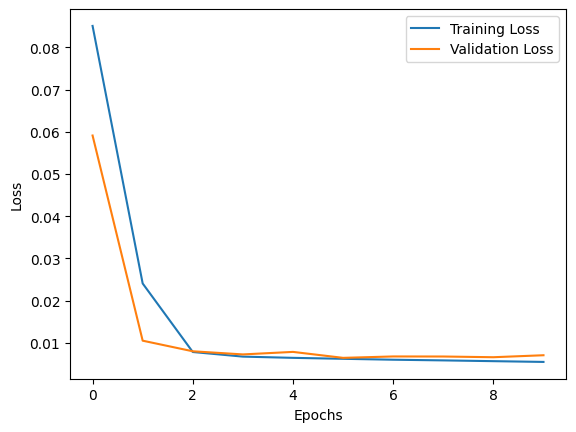

Best Validation Loss: 0.006447906140238047


In [36]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
val_data = val_data.reshape(val_data.shape[0], val_data.shape[1], 1)

history = model.fit(train_data, train_data,
                    validation_data=(val_data, val_data),
                    epochs=10,
                    batch_size=32,
                    callbacks=[early_stopping])

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

best_val_loss = np.min(history.history['val_loss'])
print("Best Validation Loss:", best_val_loss)

# Subtask 2.4

## Visualize the data in the latent space

#### TODO
 - Take the encoder part of the model as a new model.
 - Use the encoder to map the test data to the latent space.
 - Plot the latent variables versus each other. 

 **Note:** Do not forget to add title, axis labels and a legend!
This applies in general, please keep in mind.

In [42]:
####################
## YOUR CODE HERE ##
####################

encoder_model = Model(inputs=input_layer, outputs=bottleneck)
latent_space = encoder_model.predict(data_test[0])
latent_var1 = latent_space[:, 0, 0]
latent_var2 = latent_space[:, 0, 1]


666/666 [==============================] - 0s 566us/step


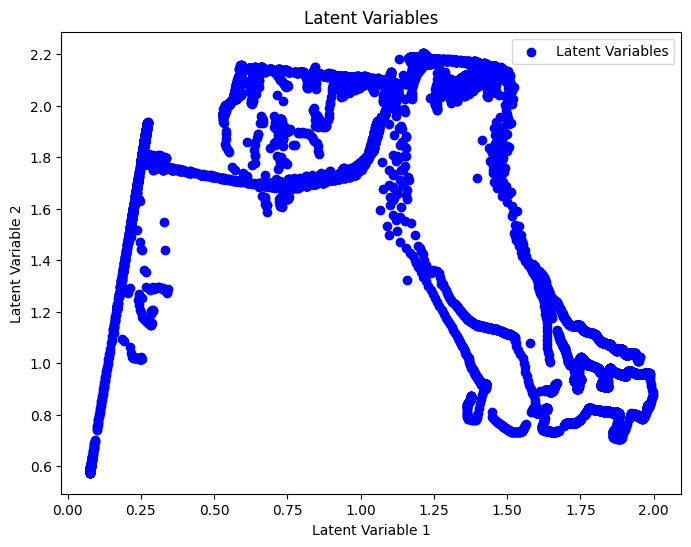

In [43]:
####################
## YOUR CODE HERE ##
####################

plt.figure(figsize=(8, 6))
plt.scatter(latent_var1, latent_var2, color='blue', label='Latent Variables')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Latent Variables')
plt.legend()
plt.show()

# Subtask 2.5

## Size of the latent vector (bottleneck layer)

#### TODO
 - Use the CNN-based autoencoder.
 - Change the size of the bottleneck layer to 2, 4, 8, 16.
 - Train the model.
 - Select the best model based on the validation loss.
  - Report the best validation loss you obtained for each model.
 - Plot the best validation loss for each model versus the size of the bottleneck layer.

 **Note:** Do not forget to add title, axis labels and a legend!
This applies in general, please keep in mind.


Epoch 1/10
533/533 [==============================] - 2s 2ms/step - loss: 0.0985 - val_loss: 0.0154
Epoch 2/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0126 - val_loss: 0.0096
Epoch 3/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 4/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0078 - val_loss: 0.0093
Epoch 5/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 6/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 7/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 8/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 9/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 10/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0029

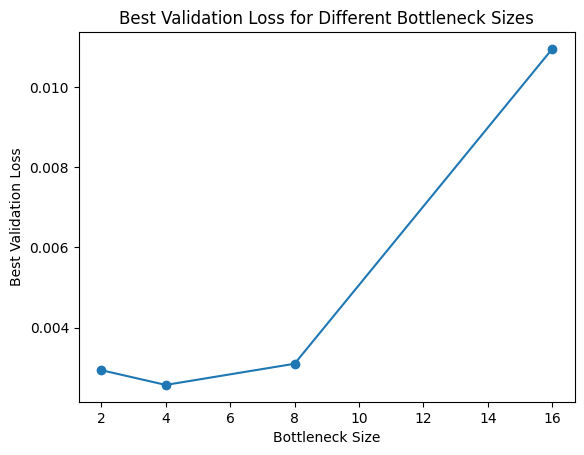

In [44]:
####################
## YOUR CODE HERE ##
####################

train_data = np.array(train_df)
val_data = np.array(val_df)

bottleneck_sizes = [2, 4, 8, 16]
best_val_losses = []

for bottleneck_size in bottleneck_sizes:
    input_shape = (6, 1)

    inputs = Input(shape=input_shape)
    x = Conv1D(16, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(8, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(bottleneck_size, kernel_size=3, activation='relu', padding='same')(x)
    encoder_output = x

    x = Conv1DTranspose(8, kernel_size=3, activation='relu', padding='same')(encoder_output)
    x = UpSampling1D(size=3)(x)
    x = Conv1DTranspose(16, kernel_size=3, activation='relu', padding='same')(x)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(1, kernel_size=3, activation='linear', padding='same')(x)
    decoder_output = x

    model = Model(inputs, decoder_output)

    model.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

    train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
    val_data = val_data.reshape(val_data.shape[0], val_data.shape[1], 1)

    history = model.fit(train_data, train_data,
                        validation_data=(val_data, val_data),
                        epochs=10,
                        batch_size=32,
                        callbacks=[early_stopping])

    best_val_loss = np.min(history.history['val_loss'])
    best_val_losses.append(best_val_loss)

plt.plot(bottleneck_sizes, best_val_losses, marker='o')
plt.title('Best Validation Loss for Different Bottleneck Sizes')
plt.xlabel('Bottleneck Size')
plt.ylabel('Best Validation Loss')
plt.show()



# Subtask 2.6

## Scheduled learning rate

When training a model, it is often useful to lower the learning rate as the training progresses. A learning rate schedule is a predefined mechanism that adjusts the learning rate between optimization steps during the training. [`tf.keras.optimizers.schedules`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules) provides several methods.


#### TODO
 - Consider the size of the bottleneck layer equal to 2.
 - Change the optimizer to use an exponential decay schedule: `tf.keras.optimizers.schedules.ExponentialDecay`.
 - Set the initial learning rate equal to 0.01.
 - Train the model and report the lowest validation loss.
 


In [48]:
####################
## YOUR CODE HERE ##
####################

train_data = np.array(train_df)
val_data = np.array(val_df)

input_shape = (6, 1)
bottleneck_size = 2

inputs = Input(shape=input_shape)
x = Conv1D(16, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(8, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(bottleneck_size, kernel_size=3, activation='relu', padding='same')(x)
encoder_output = x

x = Conv1DTranspose(8, kernel_size=3, activation='relu', padding='same')(encoder_output)
x = UpSampling1D(size=2)(x)
x = Conv1DTranspose(16, kernel_size=3, activation='relu', padding='same')(x)
x = UpSampling1D(size=3)(x)
x = Conv1D(1, kernel_size=3, activation='linear', padding='same')(x)
decoder_output = x

model = Model(inputs, decoder_output)

initial_learning_rate = 0.01
decay_steps = 1000
decay_rate = 0.9
learning_rate_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate)

optimizer = Adam(learning_rate=learning_rate_schedule)
model.compile(optimizer=optimizer, loss='mse')


In [49]:
####################
## YOUR CODE HERE ##
####################
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
val_data = val_data.reshape(val_data.shape[0], val_data.shape[1], 1)

history = model.fit(train_data, train_data,
                    validation_data=(val_data, val_data),
                    epochs=10,
                    batch_size=32,
                    callbacks=[early_stopping])

lowest_val_loss = np.min(history.history['val_loss'])
print("Lowest Validation Loss:", lowest_val_loss)

Epoch 1/10


533/533 [==============================] - 2s 2ms/step - loss: 0.0518 - val_loss: 0.0124
Epoch 2/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0089 - val_loss: 0.0044
Epoch 3/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0044
Epoch 4/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 5/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 6/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 7/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 8/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 9/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 10/10
533/533 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0036
Lowest Val

# Subtask 2.7

## Challenge

#### TODO
 - Use the CNN-based autoencoder.
 - Consider the size of the bottleneck layer equal to 8.
 - Modify the model architecture and the training process to obtain a better performance in reconstruction.
 - Select the best model based on the validation loss.
 - Plot the learning curves.
 - Report the best validation loss.

In [184]:
####################
## YOUR CODE HERE ##
####################
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Conv1DTranspose, UpSampling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import LeakyReLU


train_data = np.array(train_df)
val_data = np.array(val_df)

input_shape = (6, 1)
bottleneck_size = 4

# Encoder
inputs = Input(shape=input_shape)

x = Conv1D(128, kernel_size=7, padding='same')(inputs)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(64, kernel_size=7, padding='same')(inputs)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(32, kernel_size=7,  padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(bottleneck_size, kernel_size=3, activation='relu', padding='same')(x)
encoder_output = x

# Decoder
x = Conv1DTranspose(128, kernel_size=7,  padding='same')(encoder_output)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling1D(size=2)(x)

x = Conv1DTranspose(64, kernel_size=7, padding='same')(encoder_output)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling1D(size=2)(x)


x = Conv1DTranspose(32, kernel_size=7,  padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling1D(size=3)(x)


x = Conv1D(1, kernel_size=7, activation='linear', padding='same')(x)
x = LeakyReLU()(x)
decoder_output = x

model = Model(inputs, decoder_output)



Epoch 1/50
1065/1065 [==============================] - 4s 3ms/step - loss: 0.3058 - val_loss: 0.1769
Epoch 2/50
1065/1065 [==============================] - 3s 2ms/step - loss: 0.2089 - val_loss: 0.1115
Epoch 3/50
1065/1065 [==============================] - 3s 2ms/step - loss: 0.1526 - val_loss: 0.0795
Epoch 4/50
1065/1065 [==============================] - 3s 2ms/step - loss: 0.1161 - val_loss: 0.0684
Epoch 5/50
1065/1065 [==============================] - 3s 2ms/step - loss: 0.0927 - val_loss: 0.0589
Epoch 6/50
1065/1065 [==============================] - 3s 2ms/step - loss: 0.0753 - val_loss: 0.0508
Epoch 7/50
1065/1065 [==============================] - 2s 2ms/step - loss: 0.0618 - val_loss: 0.0426
Epoch 8/50
1065/1065 [==============================] - 3s 2ms/step - loss: 0.0514 - val_loss: 0.0363
Epoch 9/50
1065/1065 [==============================] - 2s 2ms/step - loss: 0.0451 - val_loss: 0.0307
Epoch 10/50
1065/1065 [==============================] - 3s 2ms/step - loss: 0.038

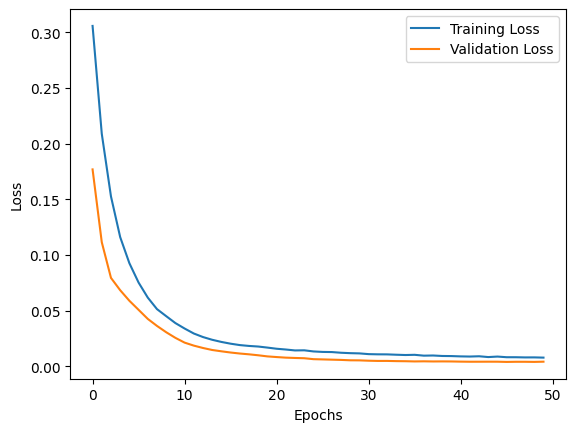

Best Validation Loss: 0.003986538387835026


In [185]:
####################
## YOUR CODE HERE ##
####################


model.compile(Adam(learning_rate=0.000001), loss='mse')

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
val_data = val_data.reshape(val_data.shape[0], val_data.shape[1], 1)

history = model.fit(train_data, train_data,
                    validation_data=(val_data, val_data),
                    epochs=50,
                    batch_size=16,
                    callbacks=[early_stopping])

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

best_val_loss = np.min(history.history['val_loss'])
print('Best Validation Loss:', best_val_loss)

# Subtask 2.8

## Reconstruction loss

#### TODO
 - Use the best model you have trained.
 - Compute the reconstruction loss for validation and test dataset.
    - You need to compute the loss for every time step.



In [190]:
####################
## YOUR CODE HERE ##
####################

test_data = data_test[0].values
val_data = val_data.reshape(val_data.shape[0], val_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)


In [191]:
####################
## YOUR CODE HERE ##
####################

val_loss = model.evaluate(val_data, val_data, verbose=0)
print('Reconstruction Loss for Validation Dataset:', val_loss)

test_loss = model.evaluate(test_data, test_data, verbose=0)
print('Reconstruction Loss for Test Dataset:', test_loss)

Reconstruction Loss for Validation Dataset: 0.004201704636216164
Reconstruction Loss for Test Dataset: 0.0037204984109848738


# Subtask 2.9

## Anomaly detection

#### TDOD
- Use the test dataset.
- Plot the ROC and precision-recall curves and report the area under the curve (AUC) for each of them.
- Select the threshold by allowing a false positive rate of 0.2.
- Detect anomalies using the threshold. 

  1/666 [..............................] - ETA: 9s

666/666 [==============================] - 1s 1ms/step
AUC for Column 0 - ROC: 0.5146, Precision-Recall: 0.4509
AUC for Column 1 - ROC: 0.6418, Precision-Recall: 0.7403
AUC for Column 2 - ROC: 0.7342, Precision-Recall: 0.4289
AUC for Column 3 - ROC: 0.5016, Precision-Recall: 0.1911
AUC for Column 4 - ROC: 0.4480, Precision-Recall: 0.2686
AUC for Column 5 - ROC: 0.3761, Precision-Recall: 0.3121
Anomalies for Column 0: [  109   110   111 ... 21013 21014 21017]
Anomalies for Column 1: [    0     1     2 ... 20773 20774 20775]
Anomalies for Column 2: [    0     1     2 ... 21265 21266 21267]
Anomalies for Column 3: [    0     1     2 ... 20744 20745 20746]
Anomalies for Column 4: [    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    5

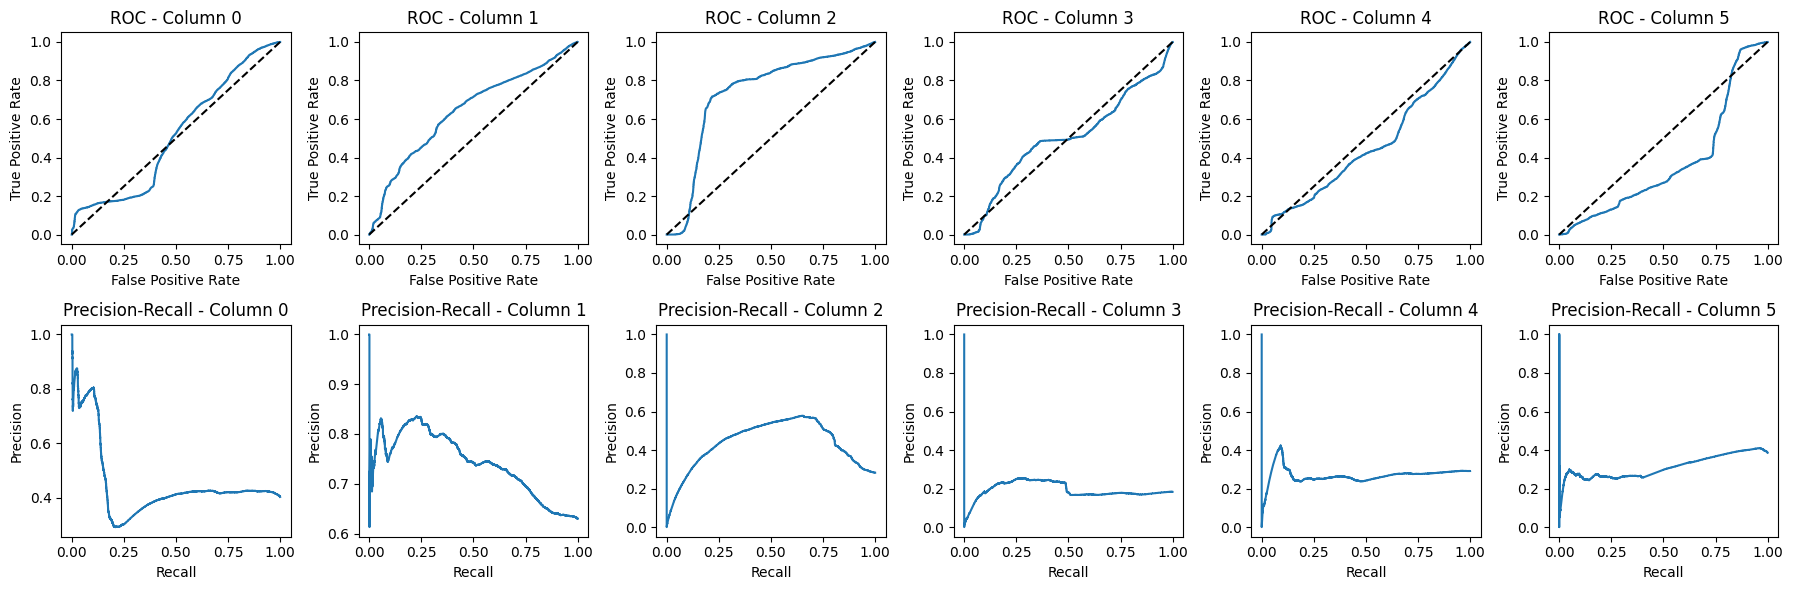

In [192]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

reconstructed_test_data = model.predict(test_data)

reconstruction_loss = np.mean(np.square(test_data - reconstructed_test_data), axis=2)

roc_auc_values = []
pr_auc_values = []

fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for i in range(len(y_test)):
    row = i // 6
    col = i % 6

    fpr, tpr, _ = roc_curve(y_test[i], reconstruction_loss[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)

    precision, recall, _ = precision_recall_curve(y_test[i], reconstruction_loss[:, i])
    pr_auc = auc(recall, precision)
    pr_auc_values.append(pr_auc)

    axes[row, col].plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    axes[row, col].plot([0, 1], [0, 1], 'k--')
    axes[row, col].set_xlabel('False Positive Rate')
    axes[row, col].set_ylabel('True Positive Rate')
    axes[row, col].set_title('ROC - Column %d' % i)

    axes[row + 1, col].plot(recall, precision, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)
    axes[row + 1, col].set_xlabel('Recall')
    axes[row + 1, col].set_ylabel('Precision')
    axes[row + 1, col].set_title('Precision-Recall - Column %d' % i)

plt.tight_layout()

for i in range(len(y_test)):
    print('AUC for Column %d - ROC: %.4f, Precision-Recall: %.4f' % (i, roc_auc_values[i], pr_auc_values[i]))

threshold = np.percentile(reconstruction_loss, 80)  

anomalies = []
for i in range(len(y_test)):
    column_anomalies = np.where(reconstruction_loss[:, i] >= threshold)[0]
    anomalies.append(column_anomalies)

for i in range(len(y_test)):
    print('Anomalies for Column %d: %s' % (i, anomalies[i]))


# Subtask 2.10

## Evaluate model performance

#### TODO
 - Compute accuracy, recall, precision f1-score.
 - Explain the effect of selecting different values for the threshold on the performance of the model.

In [193]:
####################
## YOUR CODE HERE ##
####################

TP = []
FP = []
TN = []
FN = []

for i in range(len(y_test)):
    common_indices = np.intersect1d(anomalies[i], np.where(y_test[i] == 1))
    column_TP = len(common_indices)
    column_FP = len(anomalies[i]) - column_TP
    column_TN = len(np.where(y_test[i] == 0)[0]) - len(common_indices)
    column_FN = len(np.where(y_test[i] == 1)[0]) - column_TP

    TP.append(column_TP)
    FP.append(column_FP)
    TN.append(column_TN)
    FN.append(column_FN)

accuracy = []
recall = []
precision = []
f1_score = []

for i in range(len(y_test)):
    column_accuracy = (TP[i] + TN[i]) / (TP[i] + FP[i] + TN[i] + FN[i])
    column_recall = TP[i] / (TP[i] + FN[i])
    column_precision = TP[i] / (TP[i] + FP[i])
    column_f1_score = 2 * (column_precision * column_recall) / (column_precision + column_recall)

    accuracy.append(column_accuracy)
    recall.append(column_recall)
    precision.append(column_precision)
    f1_score.append(column_f1_score)

metrics_data = {'Column': range(len(y_test)),
                'Accuracy': accuracy,
                'Recall': recall,
                'Precision': precision,
                'F1-Score': f1_score}

metrics_df = pd.DataFrame(metrics_data)

print('Metrics DataFrame:')
print(metrics_df)

print('Overall Performance Metrics:')
print('Average Accuracy: %.4f' % np.mean(accuracy))
print('Average Recall: %.4f' % np.mean(recall))
print('Average Precision: %.4f' % np.mean(precision))
print('Average F1-Score: %.4f' % np.mean(f1_score))


Metrics DataFrame:
   Column  Accuracy    Recall  Precision  F1-Score
0       0  0.547920  0.191765   0.315244  0.238468
1       1  0.443838  0.350805   0.800034  0.487742
2       2  0.731382  0.482690   0.536243  0.508059
3       3  0.759104  0.170669   0.227288  0.194951
4       4  0.690959  0.024980   0.181075  0.043903
5       5  0.552097  0.175155   0.273954  0.213687
Overall Performance Metrics:
Average Accuracy: 0.6209
Average Recall: 0.2327
Average Precision: 0.3890
Average F1-Score: 0.2811


## Visualize the detected anomalies

#### TDOD
 - Plot `ENGINE_RPM` of one of the time series of the test dataset.
 - Visualize the healthy time steps by blue.
 - Visualize the true anomalous time steps by green.
 - Visualize the predicted anomalous time steps by red.

In [225]:
time_series_index = 0

time_steps = range(len(test_data))
true_labels = y_test[time_series_index]
predicted_anomalies = np.isin(time_steps, anomalies[time_series_index])
ENGINE_RPM = test_data[:, 0, :]

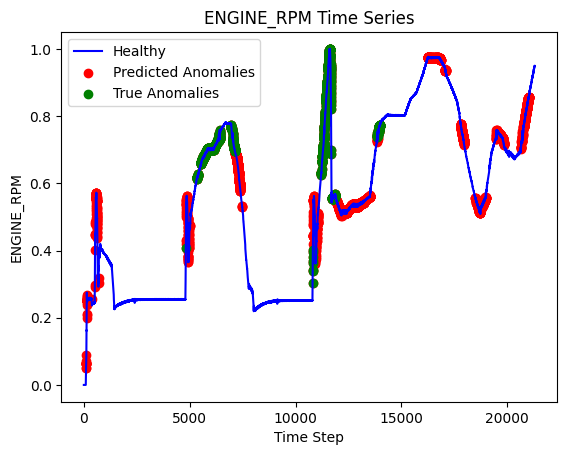

In [226]:
plt.plot(time_steps, ENGINE_RPM, color='blue', label='Healthy')
plt.scatter(np.array(time_steps)[predicted_anomalies], ENGINE_RPM[predicted_anomalies], color='red', label='Predicted Anomalies')
plt.scatter(np.array(time_steps)[np.logical_and(true_labels == 1, predicted_anomalies)],ENGINE_RPM[np.logical_and(true_labels == 1, predicted_anomalies)], color='green', label='True Anomalies')
plt.xlabel('Time Step')
plt.ylabel('ENGINE_RPM')
plt.title('ENGINE_RPM Time Series')
plt.legend()
plt.show()
